# Tests

In [1]:
Threads.nthreads()

4

In [2]:
using LinearAlgebra
using Turing
using LimberJack
using PythonCall
using NPZ
using BenchmarkTools;

In [3]:
np = pyimport("numpy");

In [4]:
meta = np.load("../data/DECALS/DECALS_meta.npz")
files = npzread("../data/DECALS/DECALS_files.npz")

tracers_names = pyconvert(Vector{String}, meta["tracers"])
pairs = pyconvert(Vector{Vector{String}}, meta["pairs"])
idx = pyconvert(Vector{Int}, meta["idx"])
data_vector = pyconvert(Vector{Float64}, meta["cls"])
cov_tot = pyconvert(Matrix{Float64}, meta["cov"])
inv_cov_tot = pyconvert(Matrix{Float64}, meta["inv_cov"]);

In [39]:
path = "/home/jaime/PhD/LimberJack.jl/chains/carlos_chains/cl_cross_corr_v3_DES_K1000_all_mag_correctMag/"
pars = np.loadtxt(string(path, "cl_cross_corr_v3_DES_K1000_all_mag_correctMag.bestfit"))
pars = pyconvert(Vector{Float64}, pars);

In [48]:
fake_cov = cov_tot ./ diag(cov_tot)

30×30 Matrix{Float64}:
  1.0          -0.0259474    -0.000419427  …  -2.41113e-10  -1.82884e-10
 -0.181156      1.0          -0.0266369       -5.3997e-10   -4.19456e-10
 -0.0103432    -0.0940853     1.0             -9.35156e-10  -7.23475e-10
  0.0325744    -0.000837397  -1.85771e-5      -2.71251e-8   -2.06149e-8
 -0.00374998    0.0254617    -0.000687186     -4.47664e-8   -3.48175e-8
 -0.000291763  -0.00241006    0.024489     …  -8.30711e-8   -6.43552e-8
 -0.000595839  -0.000166414  -0.00159835      -1.09053e-7   -8.21138e-8
 -0.000710655  -0.000273179  -0.00011139      -1.3613e-7    -9.76993e-8
 -0.000893378  -0.000301429  -0.000151768     -1.90857e-7   -1.27249e-7
 -0.00110796   -0.00035329   -0.000151826     -2.90151e-7   -1.64598e-7
  0.000166069  -4.35783e-6   -9.55869e-8   …  -3.83295e-6   -2.91373e-6
 -1.86641e-5    0.000129329  -3.41849e-6      -5.98537e-6   -4.65662e-6
 -1.06021e-6   -8.85304e-6    0.000103566     -9.02292e-6   -6.98792e-6
  ⋮                                   

In [49]:
fake_inv_cov = pinv(fake_cov)

30×30 Matrix{Float64}:
  1.00552       0.0261956     0.00111935   …   7.30066e-11   5.10582e-11
  0.182889      1.008         0.0269247        2.11181e-10   1.59394e-10
  0.0276033     0.0951019     1.00322          3.77722e-10   2.95305e-10
 -0.0328129    -0.000689234  -2.80789e-5      -3.56475e-9   -2.53393e-9
 -0.00477638   -0.0257091    -0.000641902     -7.48729e-9   -5.69279e-9
 -0.000713715  -0.00226612   -0.0246283    …  -1.44436e-8   -1.13527e-8
 -4.89883e-5   -3.02667e-6   -4.22396e-5      -1.23353e-8   -1.07957e-8
 -6.46758e-5    3.41782e-7   -3.24136e-6      -8.01687e-9   -1.00925e-8
 -8.54604e-5    2.27607e-7   -1.42882e-6      -1.02219e-9   -9.19331e-9
 -0.000102938   1.49204e-7   -1.00702e-6       1.22245e-8   -1.09698e-9
  0.0021758     4.4174e-5     1.54517e-6   …   1.0258e-7     7.54492e-8
  0.000306319   0.00165433    3.68869e-5       2.22846e-7    1.74133e-7
  4.05134e-5    0.000129679   0.00138111       3.62515e-7    2.93411e-7
  ⋮                                   

In [50]:
function get_theory(Ωm, s8;
                 data_vector=data_vector,
                 inv_cov=fake_inv_cov, 
                 tk_mode="emulator")
    
    nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31],
                     #"DECALS__0_0_dz" => pars[32],
                     #"DECALS__1_0_dz" => pars[33],
                     #"DECALS__2_0_dz" => pars[34],
                     #"DECALS__3_0_dz" => pars[35]
                     )
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)
    
    return theory

end

get_theory (generic function with 1 method)

In [63]:
fake_data = data_vector./sqrt.(diag(cov_tot))

30-element Vector{Float64}:
 20.83383452092093
 26.589992174562404
 31.189692947077432
 19.87460611040377
 24.99346252516561
 30.544710791955406
 35.726379729184174
 36.928574160937714
 41.03508035998337
 43.809846960314076
 19.683871795284787
 26.350918806510737
 30.320631148602708
  ⋮
 52.94558459556325
 19.224338855921015
 25.053253742936683
 30.534074252774452
 33.221454202219014
 38.09087933360444
 39.234288580376784
 43.44152293779922
 45.75145185413217
 51.43761380421683
 56.45180340924266
 62.31506712590762

In [64]:
#ls_tot = []
#for l in 1:length([item for item in keys(files) if occursin("ls", item)])
#    t1, t2 = pairs[l][1], pairs[l][2]
#    append!(ls_tot, files[string("ls_", t1, "_", t2)])
#end
#fake_cov = Diagonal(@.((2*data_vector^2)/((2*ls_tot+1)*0.23)))
#fake_inv_cov = inv(fake_cov)

## 2D Lkl

In [65]:
function get_Xi2(Ωm, s8;
                 data_vector=fake_data,
                 inv_cov=fake_inv_cov, 
                 tk_mode="emulator")
    nuisances = Dict(
                     "DECALS__0_0_b" => pars[28],
                     "DECALS__1_0_b" => pars[29],
                     "DECALS__2_0_b" => pars[30],
                     "DECALS__3_0_b" => pars[31])
    

    Ωb = pars[1]
    h = pars[5]
    ns = pars[4]
    
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode=tk_mode,
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, tracers_names, pairs,
                    idx, files; Nuisances=nuisances)./sqrt.(diag(cov_tot))
    
    diff = @.(theory-data_vector)
    return dot(diff, inv_cov * diff)

end

get_Xi2 (generic function with 1 method)

In [66]:
get_Xi2(0.3, 0.7)

2693.09143271614

In [67]:
Ωms = LinRange(0.1, 0.6, 20)
s8s = LinRange(0.60, 0.9, 20)

20-element LinRange{Float64, Int64}:
 0.6,0.615789,0.631579,0.647368,0.663158,…,0.852632,0.868421,0.884211,0.9

In [68]:
Xi2s_emul = zeros(length(Ωms), length(s8s))
Xi2s_EisHu = zeros(length(Ωms), length(s8s))
for i in 1:length(Ωms)
    for j in 1:length(s8s)
        Xi2s_emul[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="emulator")
        Xi2s_EisHu[i, j] = get_Xi2(Ωms[i], s8s[j]; tk_mode="EisHu")
    end
end

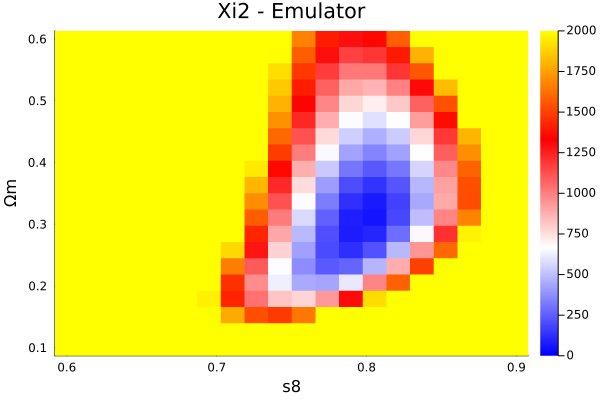

In [69]:
using Plots
gr()
heatmap(s8s, Ωms, Xi2s_emul,
    c=cgrad([:blue, :white,:red, :yellow]),
    ylabel="Ωm", xlabel="s8", clim=(0, 2000),
    title="Xi2 - Emulator")